#### NCSU GIS 714: Geospatial Computation and Simulations

## Surface Water Simulation: Introduction to Surface Water Simulation

Contents:
1. Compare flow accumulation derived by different algorithms
2. Create a map of flooded area
3. Estimate inundation extent using HAND methodology

Additional Resources:
* [GRASS GIS Overview and Manual](https://grass.osgeo.org/grass-stable/manuals/index.html)
* [GRASS book](http://www.grassbook.org/)
* For more practice in watershed analysis see [Flow and watershed analysis in GIS582](http://ncsu-geoforall-lab.github.io/geospatial-modeling-course/grass/hydrology.html)

#### Start GRASS GIS

In [1]:
#import subprocess
import sys
sys.path.append('/Applications/GRASS-8.4.app/Contents/Resources/etc/python')

# Import GRASS packages
import grass.script as gs
import grass.jupyter as gj

# Start GRASS Session
gj.init("/Users/asumi/grassdata", "nc_spm_08_grass7", "PERMANENT")



In [2]:
# Start GRASS Session
# gj.init("../data", "nc_spm_08_grass7", "PERMANENT") # somehow not working
gj.init("/Users/asumi/grassdata", "nc_spm_08_grass7", "PERMANENT")

# Make a new mapset for this assignment
# gs.run_command("g.mapset", mapset="HW3_water_simulation", location="nc_spm_08_grass7", flags="c")

### 1. Compare flow accumulation derived by different algorithms

First, we'll set region to the high resolution study area and render it.

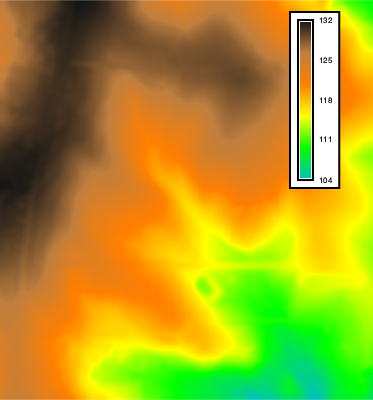

In [3]:
# Set region to the high resolution study area
gs.run_command("g.region", region="rural_1m")

# Create Map instance
gs.run_command("r.colors", map="elevation", co="elevation")
img = gj.Map(use_region=True)
img.d_rast(map="elev_lid792_1m")
img.d_legend(raster="elev_lid792_1m", at=(55, 95, 80, 84), flags="b")
# Display map
img.show()

##### Least Cost Flow Routing with Multiple Flow Direction
Then, we run least cost path flow routing with multiple flow direction (MFD), implemented with `r.watershed` ([GRASS manual for r.watershed](https://grass.osgeo.org/grass80/manuals/r.watershed.html)). We use the "a" flag to prevent negative values from partial watersheds that go over the edge of the DEM or outside the GRASS computation region.

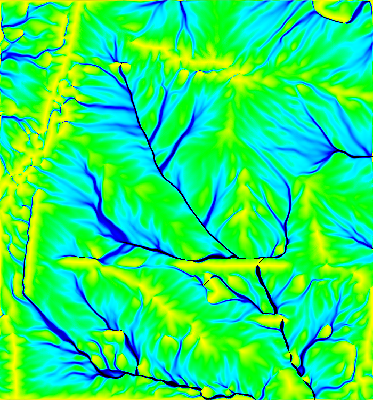

In [4]:
# Least Cost Flow Routing with MFD
gs.run_command("r.watershed", elevation="elev_lid792_1m", threshold=5000, accumulation="accum_mfd5K", drainage="draindir_5K", basin="basin_mfd5K", flags="a")
img.d_rast(map="accum_mfd5K")
img.show()

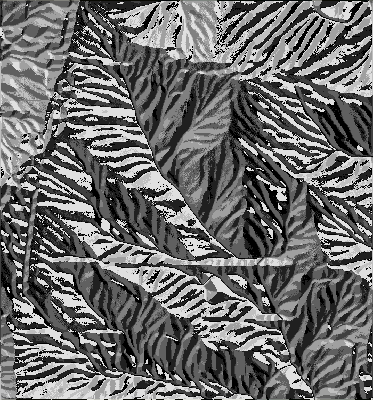

In [7]:
img.d_rast(map="draindir_5K")
img.show()

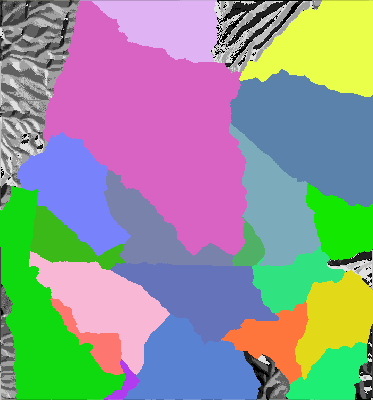

In [8]:
img.d_rast(map="basin_mfd5K")
img.show()

##### Least Cost Flow Routing with Single Flow Direction
#### *Question 1*
    
Use `r.watershed` to repeat the least cost path flow routing above but with single flow direction (SFD/D8). (hint: refer to the [GRASS manual for r.watershed](https://grass.osgeo.org/grass80/manuals/r.watershed.html) to find the appropriate flag. To add multiple flags, put all letters in the same quotations; for example, `flags="abc"`.)

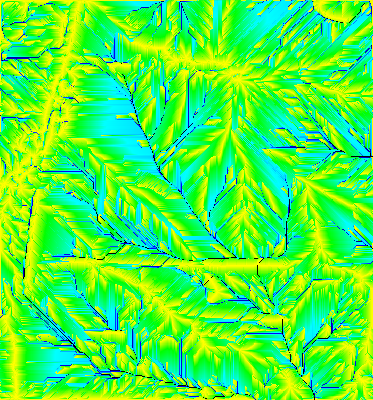

In [5]:
### Your Answer Here
# Least Cost Flow Routing with MFD
gs.run_command("r.watershed", elevation="elev_lid792_1m", threshold=5000, accumulation="accum_sfd5K", drainage="draindir_sfd5K", basin="basin_sfd5K", flags="as")
img.d_rast(map="accum_sfd5K")
img.show()

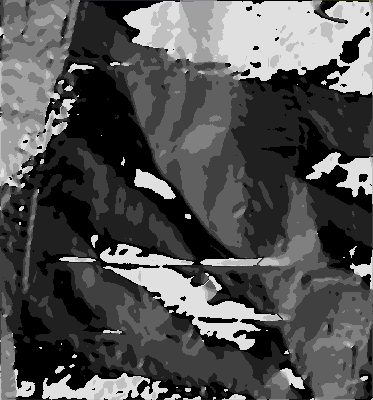

In [9]:
img.d_rast(map="draindir_sfd5K")
img.show()

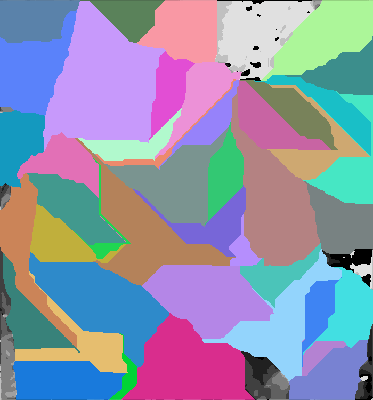

In [10]:
img.d_rast(map="basin_sfd5K")
img.show()

##### Vector-based Routing
An alternative to MFD and SFD least cost flow routing is vector-based routing (D-inf). In GRASS, this is implemented with `r.flow` ([GRASS manual for r.flow](https://grass.osgeo.org/grass80/manuals/r.flow.html)). Here, we use `r.flow` to compute flowlines, flow length and flow accumulation.

In [6]:
gs.run_command("r.flow", elevation="elev_lid792_1m", flowline="flowlines", flowlength="flowlg_vb", flowaccumulation="flowacc_vb")

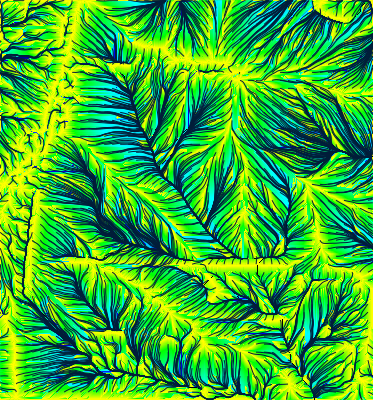

In [8]:
img.d_vect(map='flowlines')
img.show()

##### Comparison
We will compare our results by looking at the streams created by each method. Here, we demonstrate the stream extraction process for the MFD routing. We extract the streams from the flow accumulation raster by setting cells greater than 100 to 1 and all others to `null`. We thin the result to one-cell width and convert to a vector so that the streams are represented by lines.

In [7]:
# Extract Streams
gs.mapcalc("{y} = if(abs({x}) > 100, 1, null())".format(y="streams_mfd", x="accum_mfd5K"))

# Thin to one-cell width
gs.run_command("r.thin", input="streams_mfd", output="streams_mfd_t")

# Convert to vector
gs.run_command("r.to.vect", input="streams_mfd_t", out="streams_mfd_t", type="line", flags="s")

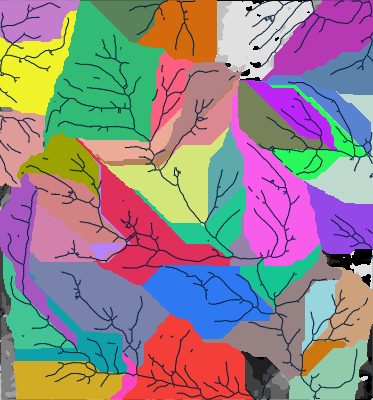

In [20]:
img.d_vect(map='streams_mfd_t')
img.show()

#### *Question 2*

Repeat stream extraction process for SFD and vector-based flow routing.

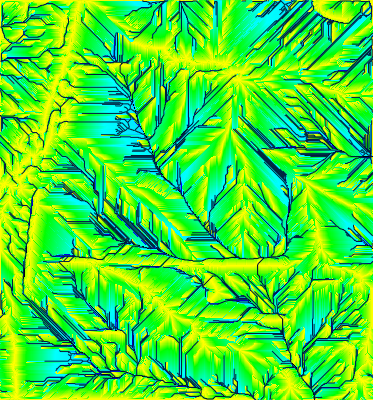

In [8]:
### Your Answer Here

# Extract Streams
gs.mapcalc("{y} = if(abs({x}) > 100, 1, null())".format(y="streams_sfd", x="accum_sfd5K"))

# Thin to one-cell width
gs.run_command("r.thin", input="streams_sfd", output="streams_sfd_t")

# Convert to vector
gs.run_command("r.to.vect", input="streams_sfd_t", out="streams_sfd_t", type="line", flags="s")

# Show the image
img.d_vect(map='streams_sfd_t')
img.show()

#### *Question 3*

Use `grass.jupyter.InteractiveMap` to visually compare the resulting stream paths and the flow accumulations, including the official Wake County streams found in `PERMANENT` (`streams@PERMANENT`).

In [ ]:
# Using InteractiveMap method
m = gj.InteractiveMap(use_region=True)
m.add_raster("elev_lid792_1m")
m.add_vector("streams_sfd_t")
m.add_vector("streams_mfd_t")
m.add_layer_control(position = "bottomright")
m.show()

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

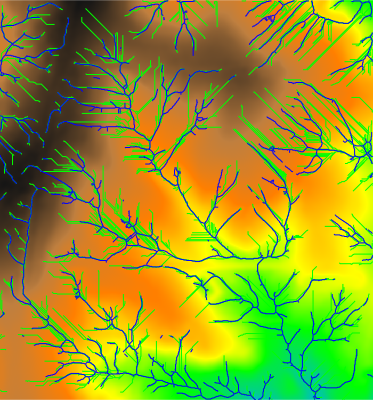

In [22]:
# Using Map method
m = gj.Map()
m.d_rast(map="elev_lid792_1m")
m.d_vect(map="streams_sfd_t", color="green")
m.d_vect(map="streams_mfd_t", color="blue")
m.show()

### 2. Create a map of flooded area
We create a map of flooded area with `r.lake` ([GRASS manual for r.lake](https://grass.osgeo.org/grass80/manuals/r.lake.html)) by providing a water level and a seed point:

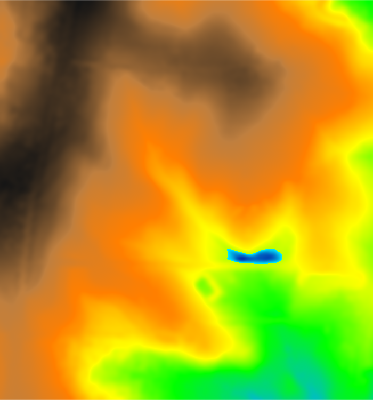

In [11]:
gs.run_command("r.lake", elevation="elev_lid792_1m", water_level=113.5, lake="flood1", coordinates="638728,220278")

# See results
img = gj.Map(use_region=True)
img.d_rast(map="elev_lid792_1m")
img.d_rast(map="flood1")
# Display map
img.show()

#### *Question 4*

Increase water level to 113.7m and 114.0m and create flooded area maps at these two levels.

In [12]:
#### Your Answer Here
gs.run_command("r.lake", elevation="elev_lid792_1m", water_level=114.0, lake="flood2", coordinates="638728,220278")

In [15]:
# Display map
img = gj.InteractiveMap(use_region=True)
img.add_raster("elev_lid792_1m")
img.add_raster("flood1", opacity=0.7)
img.add_raster("flood2", opacity=0.7)

img.add_layer_control(position = "bottomright")
img.show()

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

### 3. Estimating inundation extent using HAND methodology

We will use two GRASS addons, `r.stream.distance` and `r.lake.series`, to estimate inundation with Height Above Nearest Drainage methodology (A.D. Nobre, 2011). We need to install them first:

In [60]:
!g.extension r.stream.distance

Fetching <r.stream.distance> from <https://github.com/OSGeo/grass-addons/>
(be patient)...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 26 (delta 0), reused 0 (delta 0), pack-reused 11 (from 1)
Receiving objects: 100% (26/26), 29.66 KiB | 7.42 MiB/s, done.
Already on 'grass8'
Your branch is up to date with 'origin/grass8'.
Compiling...
ld64.lld: warning: duplicate -rpath '/Applications/GRASS-8.4.app/Contents/Resources/lib' ignored [--warn-duplicate-rpath]
Installing...
Updating extensions metadata file...
Updating extension modules metadata file...
Installation of <r.stream.distance> successfully finished


In [61]:
!g.extension r.lake.series

Fetching <r.lake.series> from <https://github.com/OSGeo/grass-addons/> (be
patient)...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 23 (delta 0), reused 0 (delta 0), pack-reused 14 (from 1)
Receiving objects: 100% (23/23), 54.17 KiB | 5.42 MiB/s, done.
Already on 'grass8'
Your branch is up to date with 'origin/grass8'.
Compiling...
Installing...
Updating extensions metadata file...
Updating extension modules metadata file...
Installation of <r.lake.series> successfully finished


For this section, we will change our computation region to `elevation` which is a larger study area than we used above. Because we are using a new region (and also a higher threshold of 100,000), we need to run `r.watershed` again to compute the flow accumulation, drainage and streams. We convert the streams to vector for better visualization.

In [62]:
gs.run_command("g.region", raster="elevation")
gs.run_command("r.watershed", elevation="elevation", accumulation="flowacc", drainage="drainage", stream="streams_100k", threshold=100000)
gs.run_command("r.to.vect", input="streams_100k", output="streams_100k", type="line")

Now we use `r.stream.distance` with output parameter difference to compute new raster where each cell is the elevation difference between the cell and the the cell on the stream where the cell drains. This is our HAND terrain model.

In [63]:
gs.run_command("r.stream.distance", stream_rast="streams_100k", direction="drainage", elevation="elevation", method="downstream", difference="above_stream")

Before we compute the inundation, we will look at how `r.lake` works. We compute a lake from specified coordinate and water level:

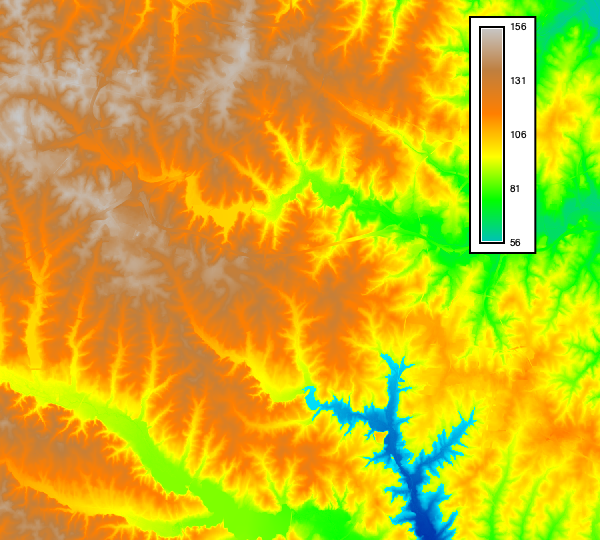

In [64]:
gs.run_command("r.lake", elevation="elevation", water_level=90, lake="lake", coordinates="637877,218475")

# See results
img = gj.Map(use_region=True)
img.d_rast(map="elevation")
img.d_rast(map="lake")
img.d_legend(raster="elevation", at=(55, 95, 80, 84), flags="b")
# Display map
img.show()

Now instead of elevation raster we use the HAND raster to simulate 5-meter inundation and, as the seed, we specify the entire stream instead of a single point.

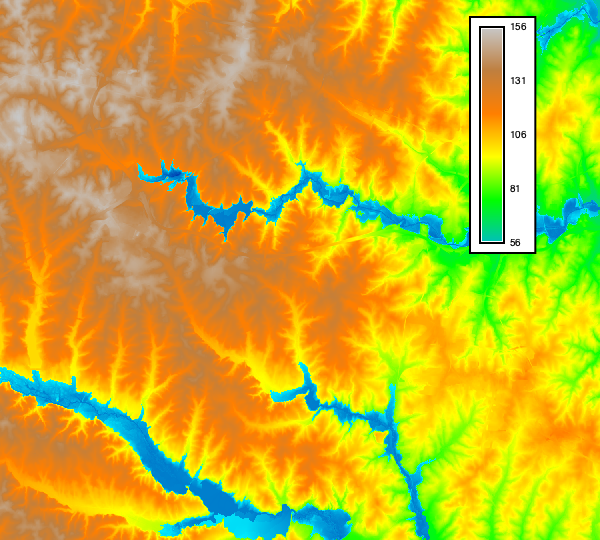

In [66]:
gs.run_command("r.lake", elevation="above_stream", water_level=5, lake="flood", seed="streams_100k")
# See results
img = gj.Map(use_region=True)
img.d_rast(map="elevation")
img.d_rast(map="flood")
img.d_legend(raster="elevation", at=(55, 95, 80, 84), flags="b")
# Display map
img.show()


With `r.lake.series`, we can create a series of inundation maps with rising water levels. `r.lake.series` creates a space-time dataset. We can use temporal modules to further work with the data. For example, we could further compute the volume and extent of flood water using `t.rast.univar`.

In [68]:
gs.run_command("r.lake.series", elevation="above_stream", start_water_level=0, end_water_level=5, water_level_step=0.5, 
               output="inundation", seed_raster="streams_100k")

print(gs.read_command("t.rast.univar", input="inundation", separator="comma"))

id,semantic_label,start,end,mean,min,max,mean_of_abs,stddev,variance,coeff_var,sum,null_cells,cells,non_null_cells
inundation_0.0@PERMANENT,,1,None,0.430362347515347,7.62939453125e-06,4,0.430362347515347,0.650724958877409,0.423442972106005,151.203970940837,839.636940002441,2023049,1951,1951
inundation_0.5@PERMANENT,,31,None,0.378565650655564,3.0517578125e-05,3.73499298095703,0.378565650655564,0.257329104353954,0.0662182679476079,67.9747631377373,12309.4406967163,1992484,32516,32516
inundation_1.0@PERMANENT,,61,None,0.677110178279069,0.000152587890625,4.23499298095703,0.677110178279069,0.369214196325271,0.136319122768116,54.5279347688524,32878.4389266968,1976443,48557,48557
inundation_1.5@PERMANENT,,91,None,0.962387091897294,3.0517578125e-05,4.73499298095703,0.962387091897294,0.507331230790872,0.257384977735781,52.715922216984,61395.4845275879,1961205,63795,63795
inundation_2.0@PERMANENT,,121,None,1.2541280654079,4.57763671875e-05,5.23499298095703,1.2541280654079,0.648919571108508,0.421

#### *Question 5*: Visualize Results
Use `grass.jupyter.TimeSeriesMap` to create an animation of the inundation.

In [70]:
### Your Code Here
img = gj.TimeSeriesMap()
img.add_raster_series("inundation")
img.d_legend(raster="elevation", at=(55, 95, 80, 84), flags="b")  # Add legend
img.show()  # Create TimeSlider

#### \[Optional\] *Question 6*: Create an animation in MapBox GL
Run the cells below then follow the [grass-mapbox-tutorial](https://github.com/ncsu-geoforall-lab/grass-mapbox-tutorial).

Here, we export each raster as a png and get the bounding box of the computational region in WGS84. We'll do this with the `r.out.leaflet.py` script from the grass-web-publishing GitHub repo. First, clone the plugin using git.

In [71]:
!git clone https://github.com/ncsu-geoforall-lab/grass-web-publishing.git

Cloning into 'grass-web-publishing'...
remote: Enumerating objects: 218, done.
remote: Total 218 (delta 0), reused 0 (delta 0), pack-reused 218 (from 1)
Receiving objects: 100% (218/218), 41.75 KiB | 4.17 MiB/s, done.
Resolving deltas: 100% (139/139), done.


Now, we'll make a new directory to store our png images and bounding box file. Then, we run the r.out.leaflet.py python script.

In [72]:
!mkdir images

In [73]:
!python3 grass-web-publishing/r.out.leaflet/r.out.leaflet.py raster="inundation_0.0,inundation_0.5,inundation_1.0,inundation_1.5,inundation_2.0,inundation_2.5,inundation_3.0,inundation_3.5,inundation_4.0,inundation_4.5,inundation_5.0" output="./images"

Reprojecting...
         renamed to <project>
Rendering...
   0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 100
Reprojecting...
         renamed to <project>
Rendering...
   0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 100
Reprojecting...
         renamed to <project>
Rendering...
   0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 100
Reprojecting...
         renamed to <project>
Rendering...
   0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 100
Reprojecting...
         renamed to <project>
Rendering...
   0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 100
Reprojecting...
         renamed to <project>
Rendering...
   0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 100
Reprojecting...
         renamed to <project>
Rendering...
   0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 100
Reprojecting...
         renamed to <project>
Rendering...
   0   6 

You will now see a few new files in the images directory

* data_file.csv    
*  data_file.js
* New pngs

If you are running this through Binder, download the images folder so you have it for the next section.

To add the newly output pngs to a web map continue by following the instructions found in the next tutorial here:

[https://github.com/ncsu-geoforall-lab/grass-mapbox-tutorial](https://github.com/ncsu-geoforall-lab/grass-mapbox-tutorial)

### Additional Information
* [Website](https://github.com/ncsu-geoforall-lab/geospatial-simulations-course)
    
* [Computing Help](https://help.ncsu.edu/)
    
* [GIST Home](https://geospatial.ncsu.edu/)
    
* [Disclaimer](https://www.ncsu.edu/policies/prr-disclaimer.php)
    
* [Accessibility](https://oit.ncsu.edu/itaccess)

* License: 2018 [CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0/)
  
* [NCSU GeoForAll Lab](https://geospatial.ncsu.edu/geoforall/)